# Metric anomaly detection

## Research Questions

1. How does IT anomaly look like and how often it occurs? 
2. Can anomaly impact be derived from anomaly itself?
3. Can anomaly be detected using LSTM autoencoder?
4. Can anomaly be predicted using LSTM autoencoder?


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta as td
from models.lstm import LSTMAutoencoder, LSTMAutoencoderParams
from models.common import HyperParams

import unittest
import numpy as np
from numpy import testing
import pandas as pd
from preprocessing.test_common import make_labels, make_series
from preprocessing.helper import TimeseriesHelper
from preprocessing.preprocessing import TimeSeriesPreprocessor
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
os.chdir(os.getcwd())

Using TensorFlow backend.


In [3]:
os.chdir('..')
print(os.getcwd())

/Users/konst/stackvista/time-series


## 1. Loading the data

We have chosen the NAB dataset for anomaly research because it seems to be only publicly available dataset that contains a representative set of timeseries with labeled anomalies.

In [4]:
helper = TimeseriesHelper()

metric_map = helper.load_multiple_series(
    ["realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv", 
     "realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv",
     "realAWSCloudwatch/ec2_disk_write_bytes_c0d644.csv",
     "realAWSCloudwatch/grok_asg_anomaly.csv",
     "realTweets/Twitter_volume_AMZN.csv",
     "realTweets/Twitter_volume_UPS.csv",
     "realTraffic/TravelTime_387.csv",
     "realKnownCause/ec2_request_latency_system_failure.csv",
     "realKnownCause/machine_temperature_system_failure.csv",
     "realKnownCause/ambient_temperature_system_failure.csv"])

## 2. How does IT anomaly look like and how often it occurs?

## 2.1 Cloud Watch: CPU Utilization.

It seems that the anomalies are pretty rare thing therefore we can expect not very balanced dataset where there will be quite many negative but almost none positive samples.


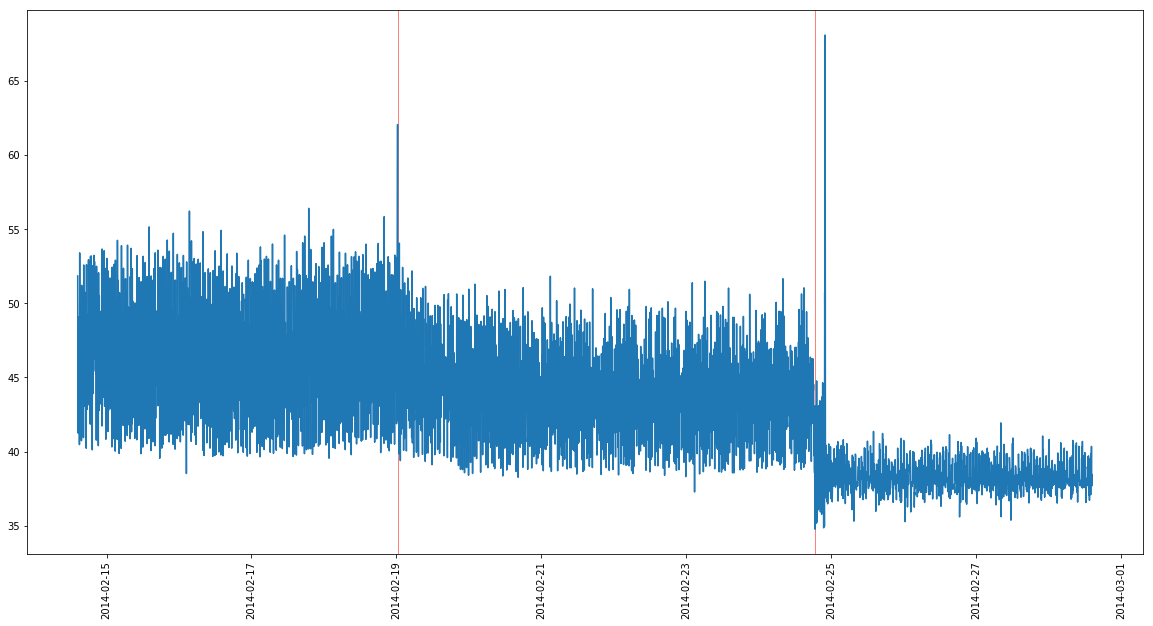

In [5]:
helper.plot_metric(metric_map["realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv"])

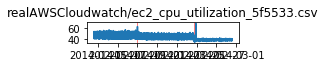

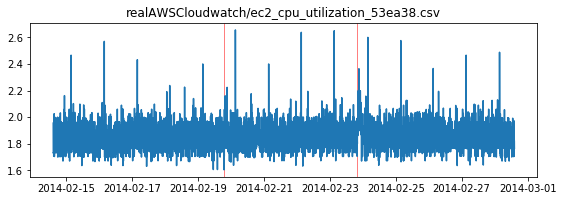

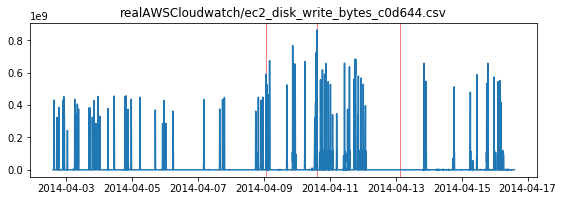

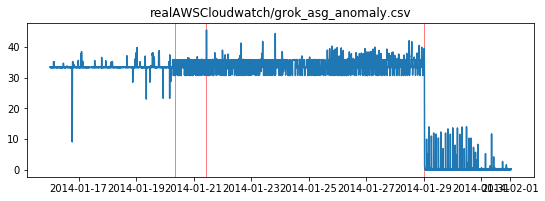

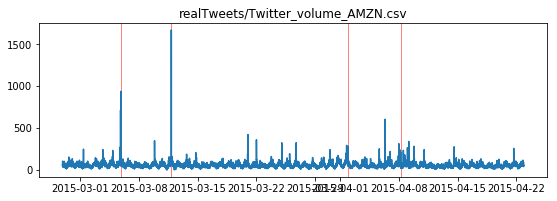

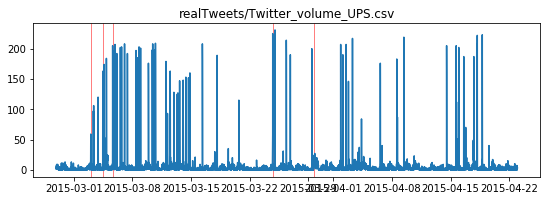

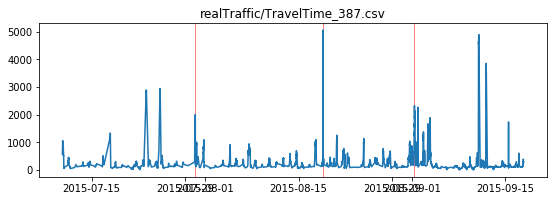

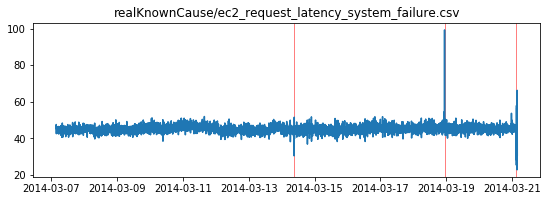

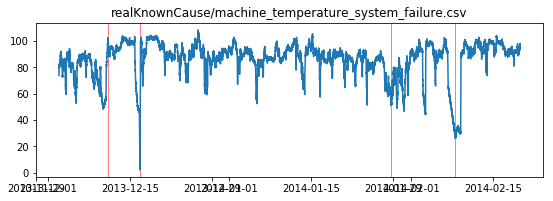

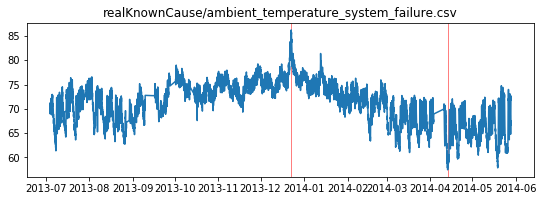

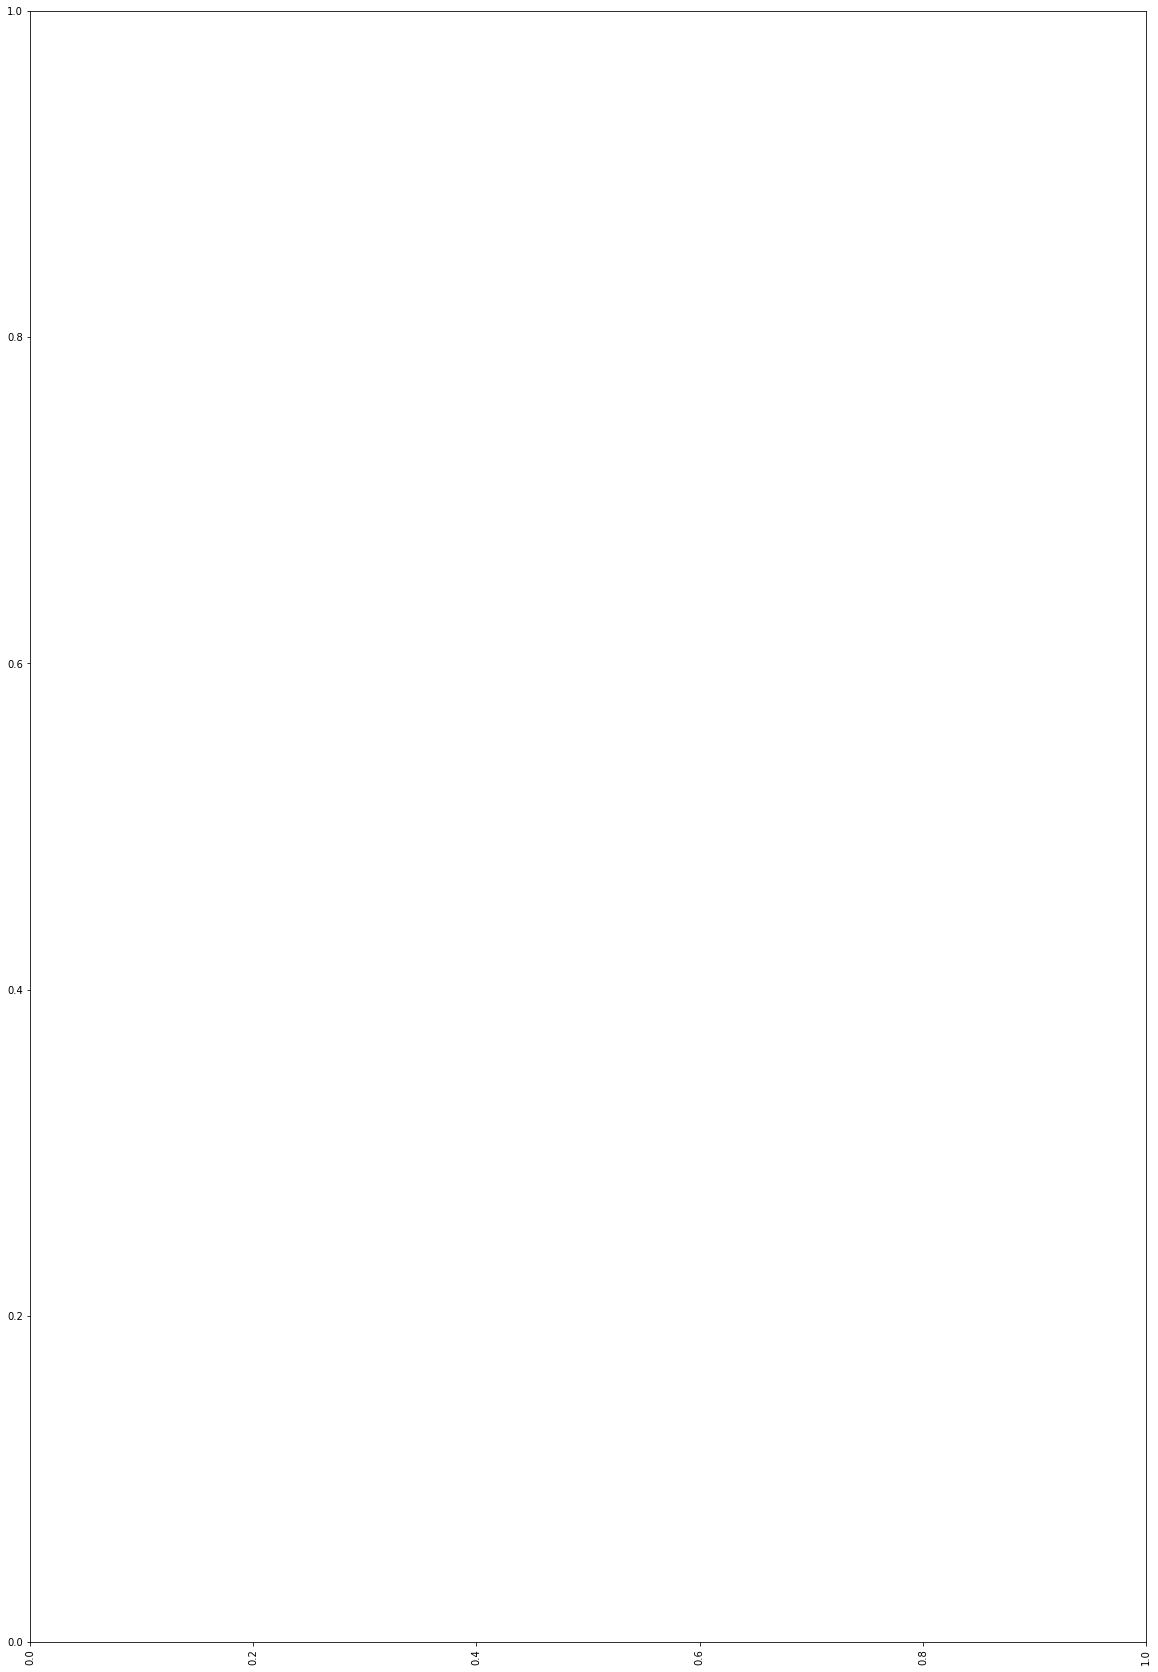

In [6]:
helper.plot_metrics(metric_map, figsize=(20, 30))

### Data Preprocessing

Metric timeseries is preprocessed before it goes to LSTM.
The following steps are executed.
1. Timeseries is cleaned from NaN values
2. We would like to preserve temporal component therefore time series is verified if for probe interval (5 minutes) exists at least one point and if it does not exists it is imputed using backfill and forward fill methods. Also if multiple points exists for probe window then they are aggregated using ???.
3. After that timeseries is choped into the samples. The sample consists of input and output variables. The sample is generated using sliding window method with shift interval - 1 hour. The input variables window is 2 hours and the output or prediction horizon is 1 hour. 

The result is the dataset almost ready for training. 

In [8]:
input_variables = ['y', 'label']
output_variables = ['label']

preprocessor = TimeSeriesPreprocessor(
    window_size_seconds = 7200,
    window_shift = 3600,
    horizon_shift_seconds = 3600,
    probe_period_seconds = 300)

windows = preprocessor.make_dataset_from_series_and_labels(data_frame,
        input_vars = input_variables, output_vars = output_variables,
        numeric_vars = ["y"], auto_impute= ["y", 'label'])

input = np.stack([w[0].to_numpy() for w in windows])
output = np.stack([w[1].to_numpy() for w in windows])


## 3. Training LSTM Autoencoder

In [7]:

n_in_features = len(input_variables)
n_out_features = len(output_variables)
timesteps_back = input.shape[1]
timesteps_forward = output.shape[1]
seed = 42
epoch_count = 1000
learning_rate = 0.0005
batch_size = 128
train_test_split_ratio = 0.2
train_valid_split_ratio = 0.3

X_train, X_test, y_train, y_test = train_test_split(input, output, test_size=train_test_split_ratio, random_state = seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=train_valid_split_ratio, random_state = seed)

lstm_params = LSTMAutoencoderParams(timesteps_back = timesteps_back, timesteps_forward = timesteps_forward,
        n_in_features = n_in_features, n_out_features = n_out_features, seed = seed)
hyper_params = HyperParams(epoch_count = epoch_count, learning_rate = learning_rate, batch_size = batch_size)
lstm = LSTMAutoencoder(lstm_params = lstm_params, hyper_params = hyper_params)
lstm.fit(X_train, y_train, X_valid, y_valid)

Y_pred = lstm.predict(X_test)


NameError: name 'data_frame' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.\n",
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return(flattened_X)

def plot_curve(X_test, Y_test, X_prediction):
    mse = np.mean(np.power(flatten(X_test) - flatten(X_prediction), 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': Y_test.tolist()})
    print(error_df)
#     precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
#     plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
#     plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
#     plt.title('Precision and recall for different threshold values')
#     plt.xlabel('Threshold')
#     plt.ylabel('Precision/Recall')
#     plt.legend()
#     plt.show()
plot_curve(X_test, y_test, Y_pred)
# helper.plot_curve(X_test, y_test, Y_pred)